In [1]:
# Config
import torch
import os
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Monitoring
from tqdm.notebook import tqdm
# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob
# Parallel processing
from joblib import Parallel, delayed
import re
from PIL import Image
import supervision as sv


from supervision.metrics import MeanAveragePrecision


from supervision.metrics.core import Metric, MetricTarget
from tempfile import mkdtemp

from tempfile import mkdtemp
from ultralytics import RTDETR

from ultralytics import YOLO


In [2]:
# --- Configuration ---
home_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025"
gt_image_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/images"
gt_obb_label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/labels"
gt_aa_labels_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/sentinel/stratified_split/test/aa_labels"
task = "aa"
conf = 0.05
iou = 0.50
imagsz = 128
epochs = 100

In [3]:
# --- Model paths dictionary ---
models = {
    "yolo_11l_obb": {
        "path": f"{home_dir}/runs_sentinel/obb/train_stratified_train_val_stratified_val__obb_yolo11l-obb_128_512_100_val_True/weights/best.pt",
        "type": "YOLO",
        "bbox_type": "obb"
    },
    "yolo_worldv2": {
        "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_worldv2-aa_128_64_100_val_True/weights/best.pt",
        "type": "YOLO",
        "bbox_type": "aa"
    },
    "yolo_12l_aa": {
        "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_v12-aa_128_64_100_val_True/weights/best.pt",
        "type": "YOLO",
        "bbox_type": "aa"
    },
    "rtdetr": {
        "path": f"{home_dir}/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_rtdetr-aa_128_64_100_val_True/weights/best.pt",
        "type": "RTDETR",
        "bbox_type": "aa"
    }
}

In [4]:
# --- Dataset config ---
data_yml_save_path = mkdtemp()
data_yml = """train: dummy
val: dummy
nc: 3
names: ["CFCBK", "FCBK", "Zigzag"]
"""
data_yml_path = f"{data_yml_save_path}/data.yml"
with open(data_yml_path, "w") as f:
    f.write(data_yml)
print(f"Data yml saved to {data_yml_path}")


Data yml saved to /tmp/tmp8xn76_24/data.yml


In [5]:
for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]
    assert exists(model_path), f"Model path {model_path} does not exist."
    bbox_type = model_info["bbox_type"]
    print(f"Model path: {model_path}")
    print(f"Model type: {model_type}")
    print(f"Bounding box type: {bbox_type}")


Evaluating model: yolo_11l_obb
Model path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/runs_sentinel/obb/train_stratified_train_val_stratified_val__obb_yolo11l-obb_128_512_100_val_True/weights/best.pt
Model type: YOLO
Bounding box type: obb

Evaluating model: yolo_worldv2
Model path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_worldv2-aa_128_64_100_val_True/weights/best.pt
Model type: YOLO
Bounding box type: aa

Evaluating model: yolo_12l_aa
Model path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/runs_sentinel/detect/train_stratified_train_val_stratified_val__detect_yolo_v12-aa_128_64_100_val_True/weights/best.pt
Model type: YOLO
Bounding box type: aa

Evaluating model: rtdetr
Model path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/brick_kilns_neurips_2025/runs_sentinel/detect/trai


Evaluating model: yolo_11l_obb


100%|██████████| 15590/15590 [04:49<00:00, 53.93it/s]


target length: 15590, prediction length: 15590

Plot of Confusion Matrix at IoU 0.5

Evaluating model: yolo_worldv2


100%|██████████| 15590/15590 [03:46<00:00, 68.68it/s]


target length: 15590, prediction length: 15590

Plot of Confusion Matrix at IoU 0.5

Evaluating model: yolo_12l_aa


100%|██████████| 15590/15590 [06:27<00:00, 40.22it/s]


target length: 15590, prediction length: 15590

Plot of Confusion Matrix at IoU 0.5

Evaluating model: rtdetr


100%|██████████| 15590/15590 [09:35<00:00, 27.11it/s]


target length: 15590, prediction length: 15590

Plot of Confusion Matrix at IoU 0.5

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| yolo_11l_obb | 75.24 | 58.85 | 55.45 | 53.93 | 41.94 | 34.86 | 31.81 | 29.37 |
| yolo_worldv2 | 80.75 | 58.08 | 62.29 | 56.92 | 49.91 | 35.20 | 39.94 | 34.40 |
| yolo_12l_aa | 79.56 | 58.39 | 60.23 | 54.87 | 48.62 | 35.29 | 38.11 | 32.42 |
| rtdetr | 87.66 | 63.43 | 68.74 | 64.36 | 53.99 | 38.28 | 43.86 | 38.77 |

### Confusion Matrix Table
| Model | IoU | Precision | Recall | F1 score | TP | FP | FN | Kiln instances |
|----|----|----|----|----|----|----|----|----|
| yolo_11l_obb | 0.50 | 0.579 | 0.684 | 0.627 | 14296 | 10406 | 6600 | 20896 |
| yolo_worldv2 | 0.50 | 0.576 | 0.728 | 0.643 | 15212 | 11199 | 5684 | 20896 |
| yolo_12l_aa | 0.50 | 0.565 | 0.711 | 0.629 | 14858 | 11462 | 6038 | 20896 |
| rtde

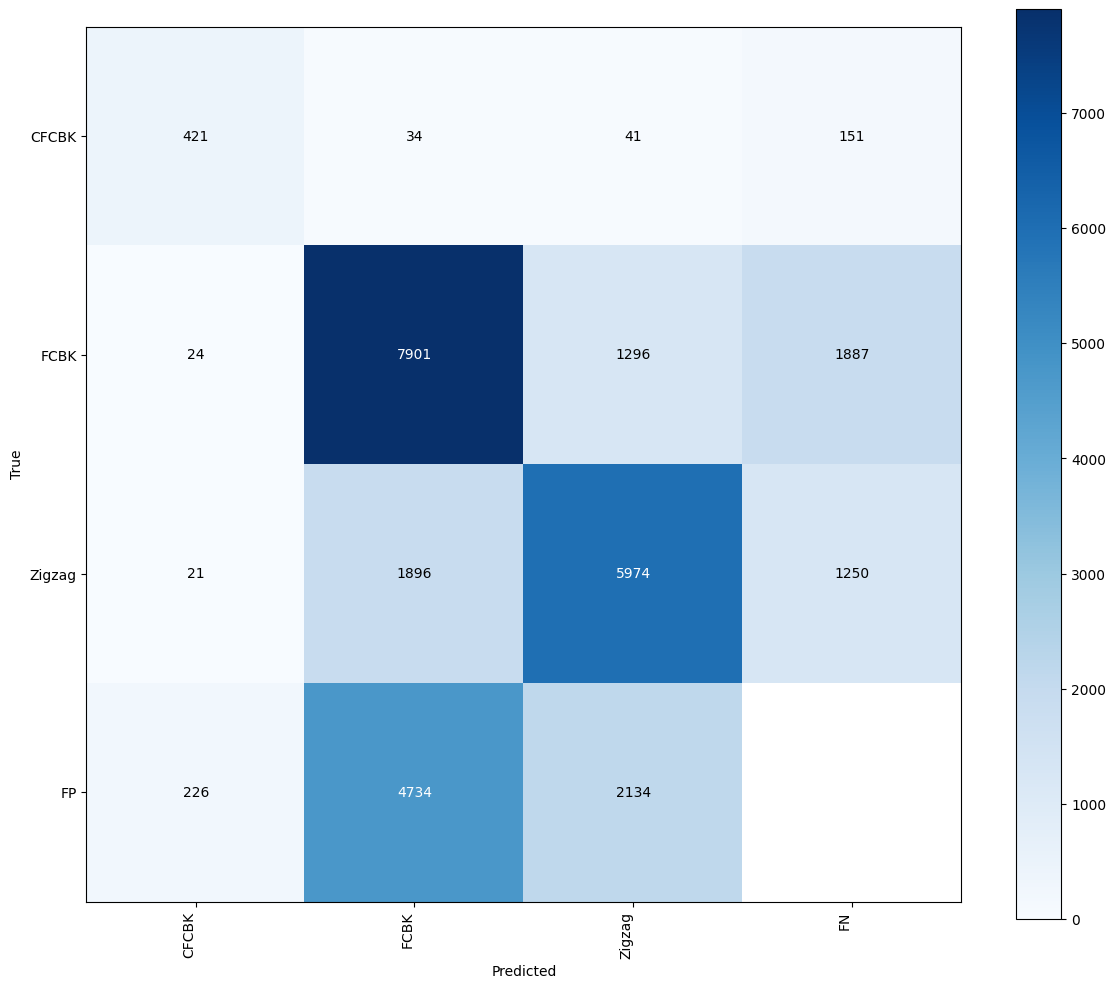

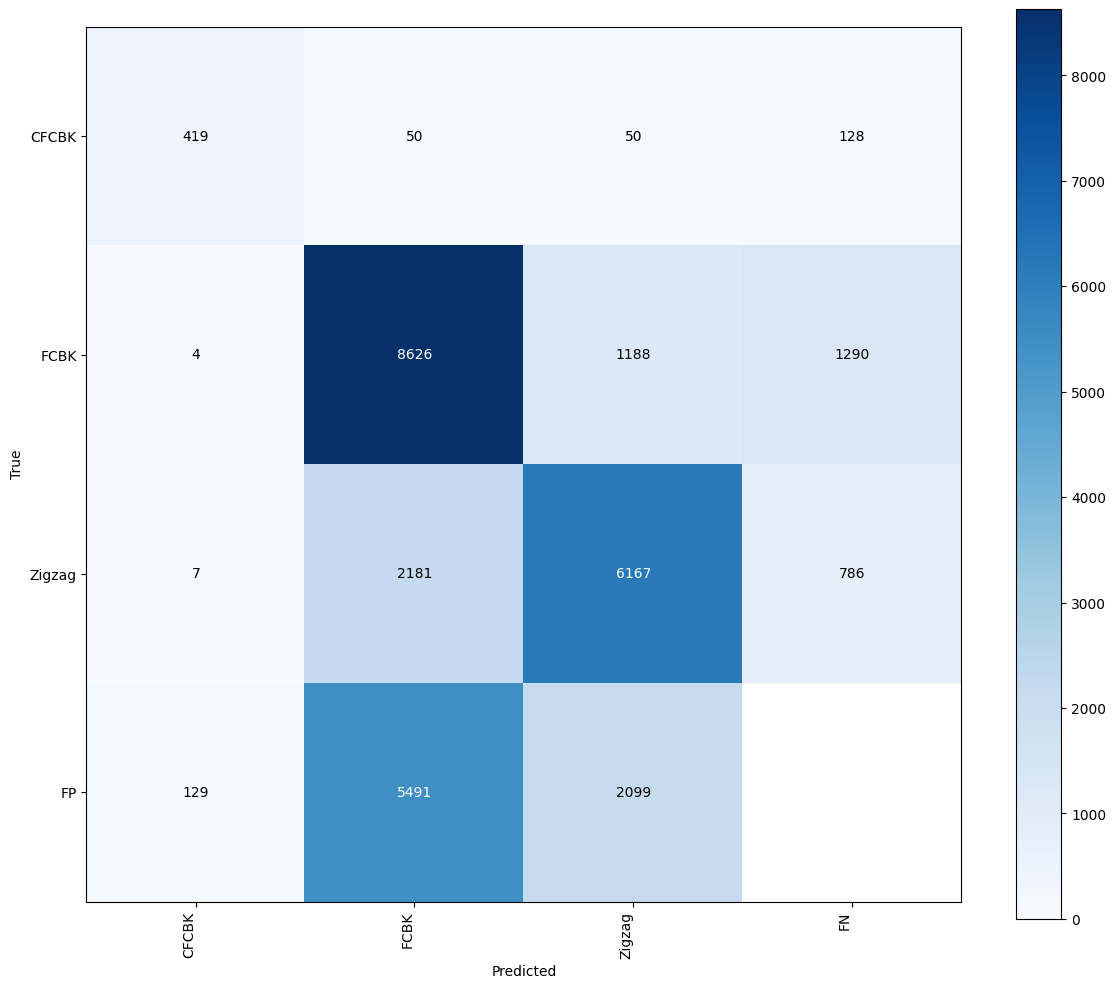

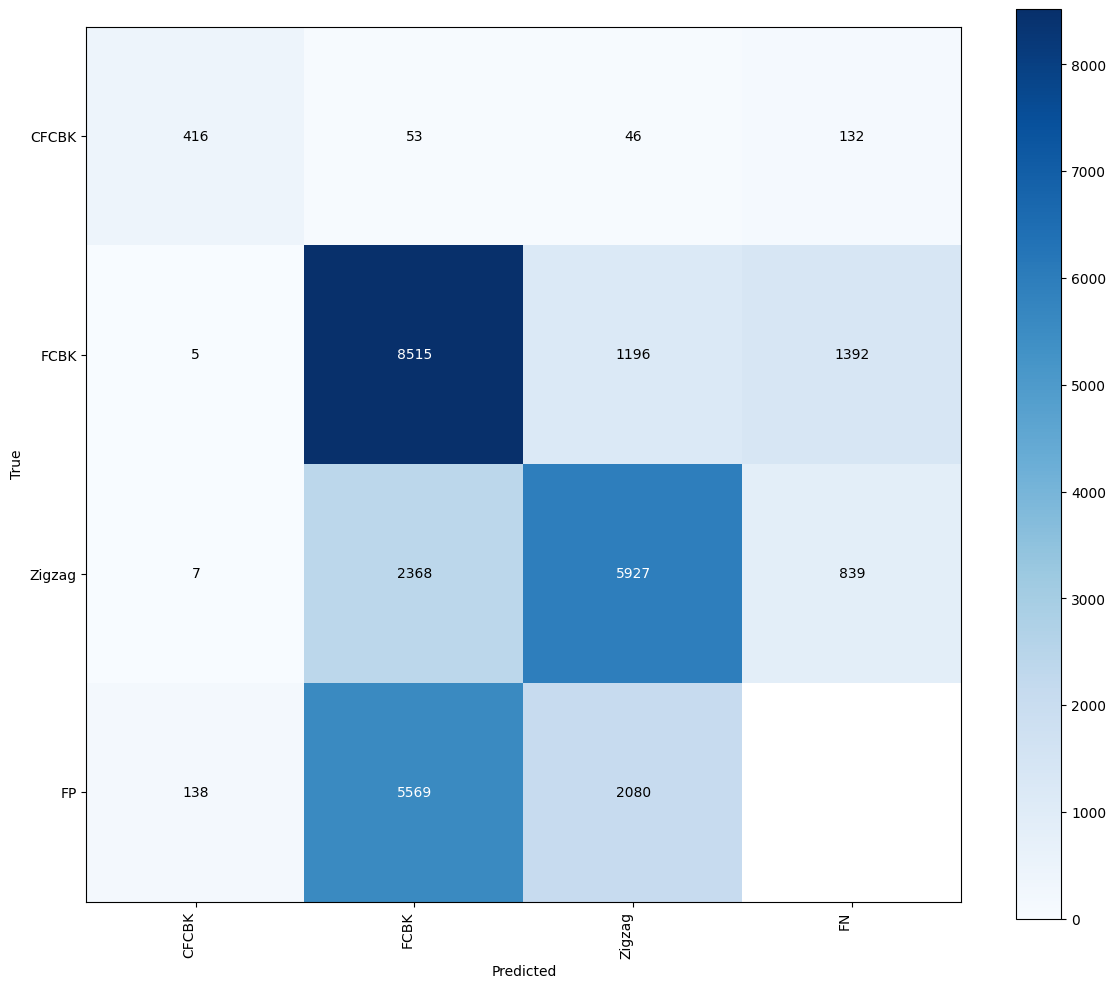

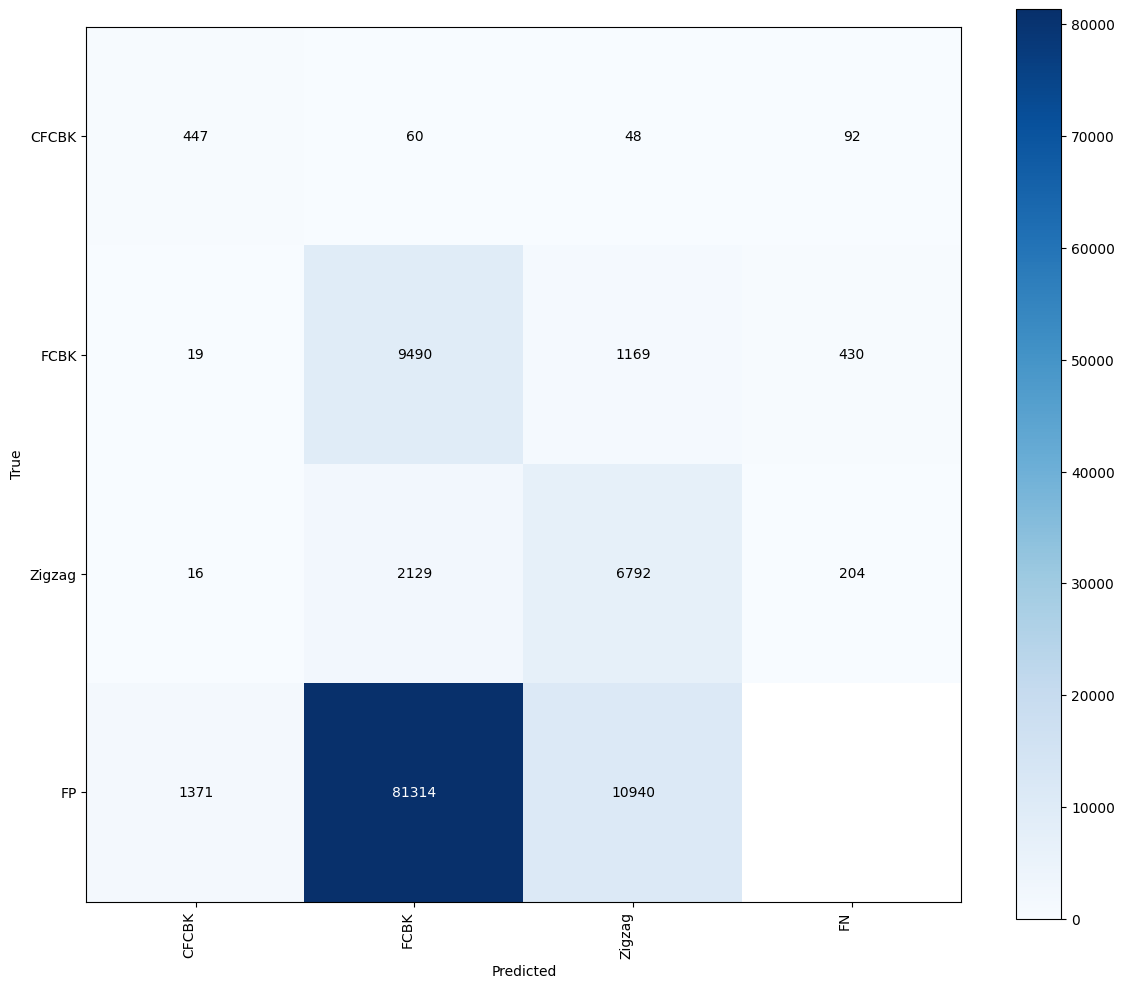

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
max_images = 5

def to_percent_list(x):
    """Converts scalar or iterable metric to list of rounded percentages."""
    if isinstance(x, (float, np.floating)):
        return [round(x * 100, 2)]
    if hasattr(x, "tolist"):
        x = x.tolist()
    return [round(val * 100, 2) for val in x]

# --- Evaluation loop ---
markdown_rows = []
cm_markdown_rows = []

for model_key, model_info in models.items():
    print(f"\nEvaluating model: {model_key}")
    model_type = model_info["type"]
    model_path = model_info["path"]

    # Determine dataset type from key
    is_obb = "obb" in model_key.lower()
    label_dir = gt_obb_label_dir if is_obb else gt_aa_labels_dir

    # Load the appropriate dataset
    sv_dataset = sv.DetectionDataset.from_yolo(
        gt_image_dir, label_dir, data_yml_path, is_obb=is_obb
    )
    CLASSES = sv_dataset.classes
    # Load model
    model = YOLO(model_path) if model_type.upper() == "YOLO" else RTDETR(model_path)

    targets, predictions = [], []

    for idx, (name, _, gt_detection) in enumerate(tqdm(sv_dataset)):
        # if idx >= max_images:
        #     break
        result = model(
            name,
            imgsz=imagsz,
            iou=iou,
            conf=conf,
            exist_ok=False,
            save_txt=False,
            max_det=300,
            verbose=False
        )[0]
        sv_detection = sv.Detections.from_ultralytics(result)
        targets.append(gt_detection)
        predictions.append(sv_detection)

    print(f"target length: {len(targets)}, prediction length: {len(predictions)}")

    # --- Class-wise mAP ---
    mAP_metric_class_wise = MeanAveragePrecision(class_agnostic=False)
    mAP_result_class_wise = mAP_metric_class_wise.update(predictions, targets).compute()


    # mAP@50 and mAP@50_90 per class
    classwise_map50 = to_percent_list(mAP_result_class_wise.ap_per_class[:, 0])        # IoU=0.50
    classwise_map50_90 = to_percent_list(mAP_result_class_wise.ap_per_class[:, :9].mean(axis=1))  # Mean over IoU 0.50:0.05:0.90

    # --- CA-mAP (class agnostic) ---
    mAP_metric_ca = MeanAveragePrecision(class_agnostic=True)
    mAP_result_ca = mAP_metric_ca.update(predictions, targets).compute()
    ca_map50 = round(mAP_result_ca.ap_per_class[:, 0][0] * 100, 2)
    ca_map50_90 = round(mAP_result_ca.ap_per_class[:, :9].mean() * 100, 2)

    # --- Prepare markdown row for mAP table ---
    row = [
        model_key,
        f"{ca_map50:.2f}", *[f"{v:.2f}" for v in classwise_map50],
        f"{ca_map50_90:.2f}", *[f"{v:.2f}" for v in classwise_map50_90]
    ]
    markdown_rows.append(row)

    # --- Confusion matrix and metrics (for IoU 0.50 only) ---
    iou = 0.50
    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,
        conf_threshold=0.05,
        iou_threshold=iou
    )
    cm = confusion_matrix.matrix
    tp1, tp2, tp3 = cm[0][0], cm[1][1], cm[2][2]
    tp = tp1 + tp2 + tp3
    predicted_positives_cfcbk = cm[:, 0].sum()
    predicted_positives_fcbk = cm[:, 1].sum()
    predicted_positives_zz = cm[:, 2].sum()
    predicted_positives = predicted_positives_cfcbk + predicted_positives_fcbk + predicted_positives_zz
    actual_positives_cfcbk = cm[0, :].sum()
    actual_positives_fcbk = cm[1, :].sum()
    actual_positives_zz = cm[2, :].sum()
    actual_positives = actual_positives_cfcbk + actual_positives_fcbk + actual_positives_zz
    precision = tp / (predicted_positives + 1e-9)
    recall = tp / (actual_positives + 1e-9)
    f1_score = 2 * precision * recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp
    false_negatives = actual_positives - tp
    # For markdown
    cm_markdown_rows.append([
        model_key, f"{iou:.2f}", f"{precision:.3f}", f"{recall:.3f}", f"{f1_score:.3f}", 
        f"{int(tp)}", f"{int(false_positives)}", f"{int(false_negatives)}", f"{int(actual_positives)}"
    ])
    print(f'\nPlot of Confusion Matrix at IoU {iou}')
    _ = confusion_matrix.plot()

# --- Print mAP Markdown Table ---
header1 = ["Model", "Class Agonostics mAP@50", "CFCBK@50", "FCBK@50", "Zigzag@50", "Class Agonostics mAP@50_90", "CFCBK@50_90", "FCBK@50_90", "Zigzag@50_90"]
print("\n### mAP Table")
print("| " + " | ".join(header1) + " |")
print("|" + "----|" * len(header1))
for row in markdown_rows:
    print("| " + " | ".join(row) + " |")

# --- Print Confusion Matrix Markdown Table ---
header2 = ["Model", "IoU", "Precision", "Recall", "F1 score", "TP", "FP", "FN", "Kiln instances"]
print("\n### Confusion Matrix Table")
print("| " + " | ".join(header2) + " |")
print("|" + "----|" * len(header2))
for row in cm_markdown_rows:
    print("| " + " | ".join(row) + " |")


### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| yolo_11l_obb | 75.24 | 58.85 | 55.45 | 53.93 | 41.94 | 34.86 | 31.81 | 29.37 |
| yolo_worldv2 | 80.75 | 58.08 | 62.29 | 56.92 | 49.91 | 35.20 | 39.94 | 34.40 |
| yolo_12l_aa | 79.56 | 58.39 | 60.23 | 54.87 | 48.62 | 35.29 | 38.11 | 32.42 |
| rtdetr | 87.66 | 63.43 | 68.74 | 64.36 | 53.99 | 38.28 | 43.86 | 38.77 |

### Confusion Matrix Table
| Model | IoU | Precision | Recall | F1 score | TP | FP | FN | Kiln instances |
|----|----|----|----|----|----|----|----|----|
| yolo_11l_obb | 0.50 | 0.579 | 0.684 | 0.627 | 14296 | 10406 | 6600 | 20896 |
| yolo_worldv2 | 0.50 | 0.576 | 0.728 | 0.643 | 15212 | 11199 | 5684 | 20896 |
| yolo_12l_aa | 0.50 | 0.565 | 0.711 | 0.629 | 14858 | 11462 | 6038 | 20896 |
| rtdetr | 0.50 | 0.147 | 0.801 | 0.248 | 16729 | 97066 | 4167 | 20896 |

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| rtdetr | 100.00 | 80.20 | 100.00 | 80.12 | 68.04 | 77.78 |

### mAP Table
| Model | Class Agonostics mAP@50 | CFCBK@50 | FCBK@50 | Zigzag@50 | Class Agonostics mAP@50_90 | CFCBK@50_90 | FCBK@50_90 | Zigzag@50_90 |
|----|----|----|----|----|----|----|----|----|
| rtdetr | 100.00 | 80.20 | 100.00 | 80.12 | 68.04 | 77.78 |